# Diabetes Dataset

## Problem List
- Dataset does not match the study protocol -> no information on physical activity
- Insulin Resistance: was imputed (should be categorical/binary, includes 0.301111 for 100 instances)
- BloodSugarLevel:
  - 100 instances were imputed with the mean
  - prevalence of 10 instances of BloodSugarLevel of 70.00000 (=min) 
  - prevalence of 6 instances of 140.00000 (max)
  - Genetic Factor: value of 0.15 in a  categorical/binary column
- Age: spike in people 20 and 80 -> most likely, younger and older people were entered to be that age
- Ethnicity: ethnicity 2 is severely underrepresented in comparision
- BMI: huge spike at 28
- Overrepresentation of the GeneticFactor 0

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

df = pd.read_csv('diabetes_study_final_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1000 non-null   int64  
 1   Gender             1000 non-null   int64  
 2   Ethnicity          1000 non-null   int64  
 3   BMI                1000 non-null   float64
 4   BloodSugarLevel    1000 non-null   float64
 5   InsulinResistance  1000 non-null   float64
 6   GeneticFactor      1000 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 54.8 KB


In [2]:
df.head(10)

,Age,Gender,Ethnicity,BMI,BloodSugarLevel,InsulinResistance,GeneticFactor
0,56,0,1,18.303039,91.118631,0.000000,0.00
1,69,0,4,28.052368,108.830756,0.301111,0.00
2,46,1,4,30.947376,91.569805,0.000000,0.00
3,32,1,0,26.874690,98.878487,0.301111,0.00
4,60,1,3,28.052368,90.062769,0.000000,0.00
5,25,1,4,30.063757,114.767044,0.000000,0.00
6,78,1,0,21.749817,117.876767,0.301111,0.00
7,38,0,2,25.883789,101.480691,0.000000,0.00
8,56,0,4,31.177059,105.573570,1.000000,0.15
9,75,0,0,22.982842,83.271129,0.000000,0.00


In this first look, we can already identify the first two problems: 
- InsulinResistance, which should be a binary column with values of either 0 or 1, contains values that are neither (specifically: 0.30111 which is the mean!).
- same for GeneticFactor being 0.15

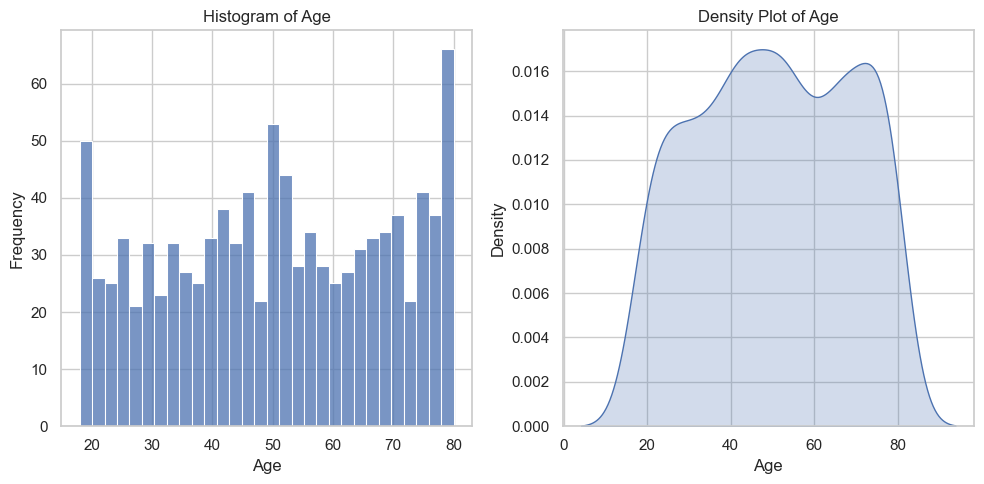

Statistics for Age:
count    1000.000000
mean       50.380000
std        18.378666
min        18.000000
25%        35.000000
50%        50.000000
75%        66.000000
max        80.000000
Name: Age, dtype: float64

Skewness: -0.06131207361588635

Kurtosis: -1.1659864966860534




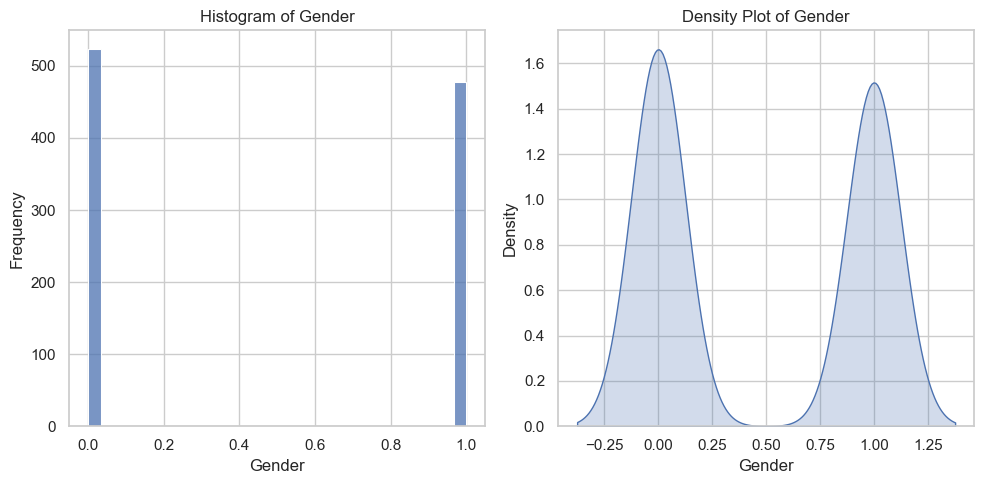

Statistics for Gender:
count    1000.000000
mean        0.477000
std         0.499721
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Gender, dtype: float64

Skewness: 0.0922359022863777

Kurtosis: -1.9954875253821587




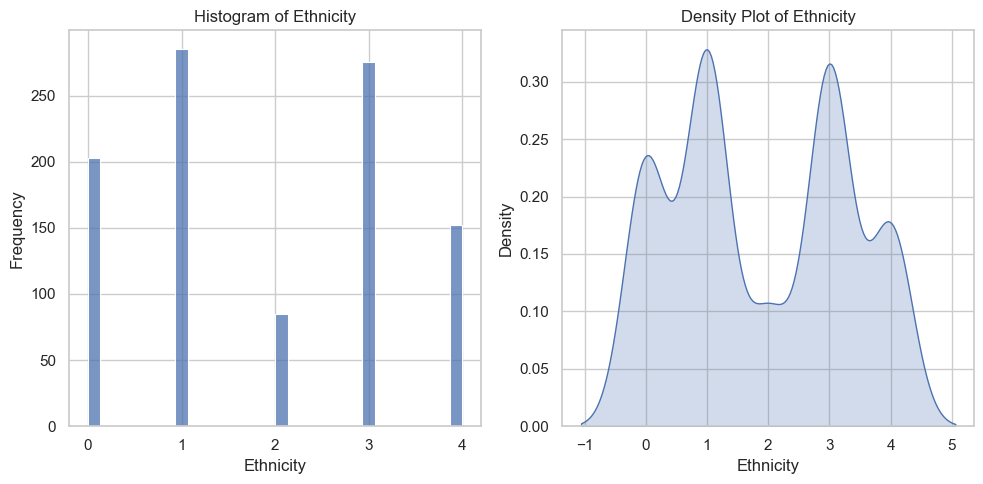

Statistics for Ethnicity:
count    1000.000000
mean        1.888000
std         1.403362
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Ethnicity, dtype: float64

Skewness: 0.08871978654083601

Kurtosis: -1.3989569130713262




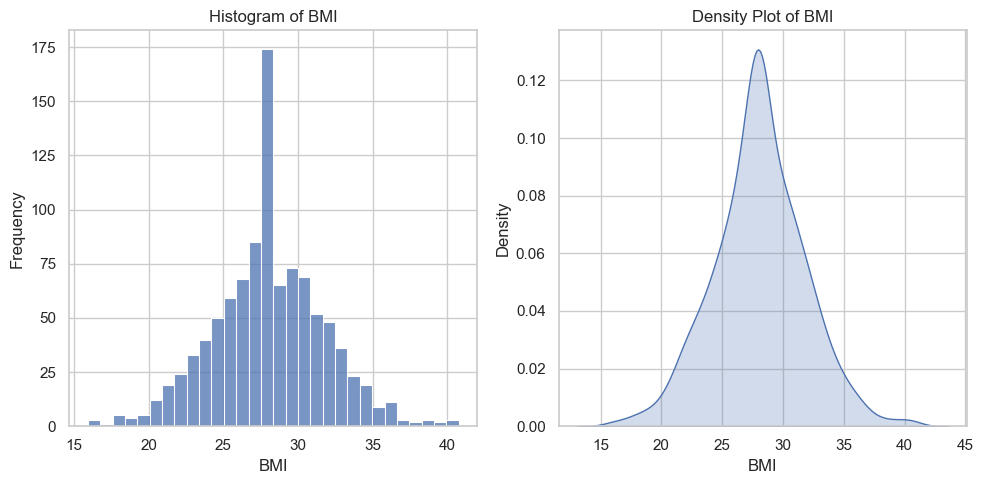

Statistics for BMI:
count    1000.000000
mean       28.052368
std         3.743058
min        15.921951
25%        25.820978
50%        28.052368
75%        30.341792
max        40.772430
Name: BMI, dtype: float64

Skewness: 0.023649854493286382

Kurtosis: 0.550131618874695




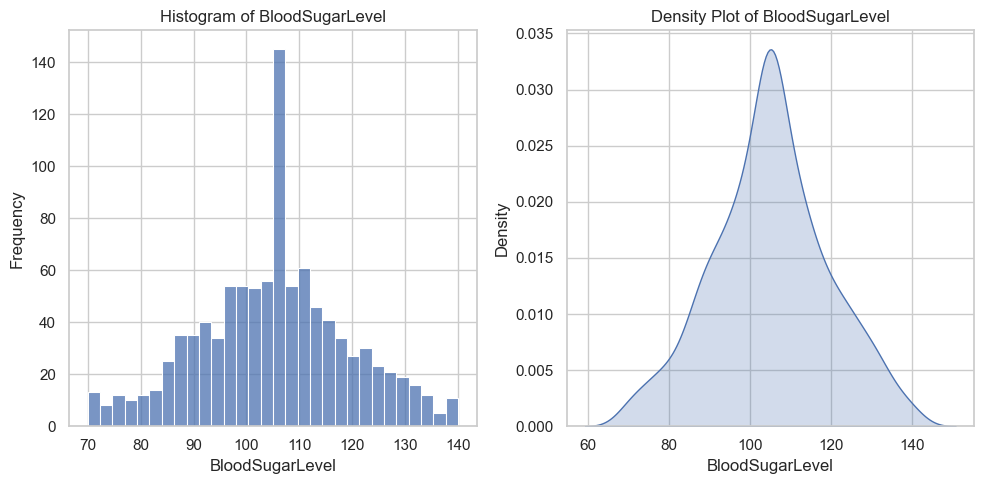

Statistics for BloodSugarLevel:
count    1000.000000
mean      105.053928
std        14.235055
min        70.000000
25%        96.149359
50%       105.053928
75%       113.705994
max       140.000000
Name: BloodSugarLevel, dtype: float64

Skewness: 0.006252079599169542

Kurtosis: -0.11722653334515787




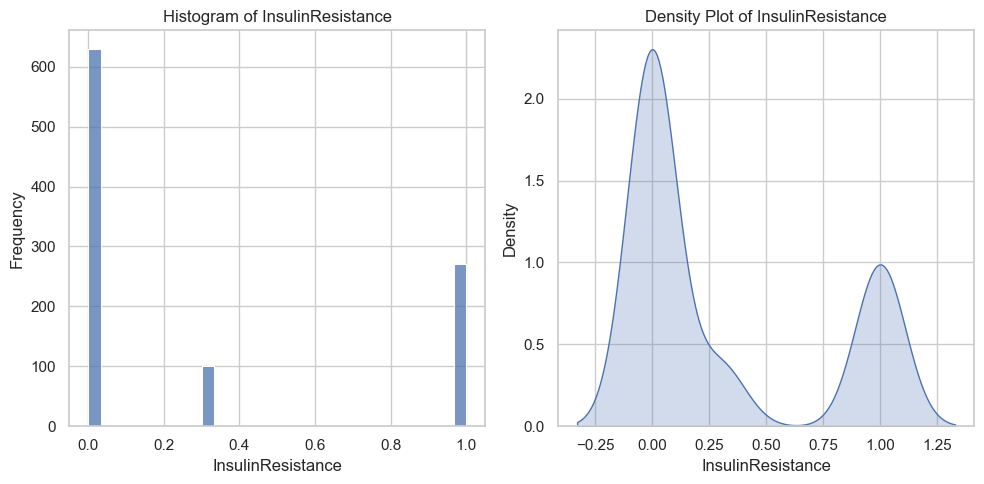

Statistics for InsulinResistance:
count    1000.000000
mean        0.301111
std         0.435418
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: InsulinResistance, dtype: float64

Skewness: 0.9153854532250741

Kurtosis: -1.05273361191403




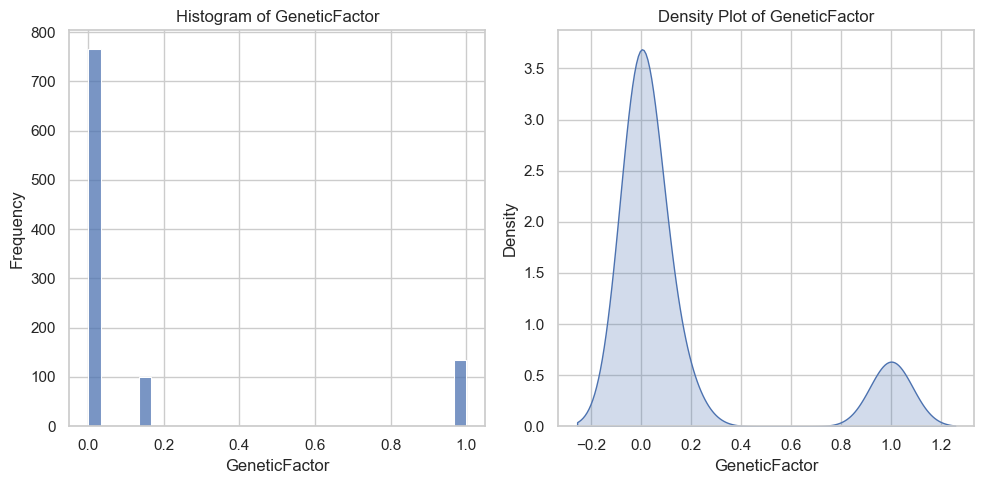

Statistics for GeneticFactor:
count    1000.000000
mean        0.150000
std         0.338917
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: GeneticFactor, dtype: float64

Skewness: 2.069540337802456

Kurtosis: 2.3992370249969546




In [3]:
import seaborn as sns

# Set the style of seaborn plots
sns.set_theme(style="whitegrid")

# Function to plot distribution of each column
def plot_distributions(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=False, bins=30)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        # Density plot (KDE)
        plt.subplot(1, 2, 2)
        sns.kdeplot(df[column], fill=True)
        plt.title(f'Density Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()
        
        # Display basic statistics
        print(f'Statistics for {column}:')
        print(df[column].describe())
        print('\nSkewness:', df[column].skew())
        print('\nKurtosis:', df[column].kurtosis())
        print('\n')

# Plot distributions
plot_distributions(df)

One error needs to be fixed before developing a first model to compare the results to: the imputation in the target column needs to be fixed, as we want a classification.

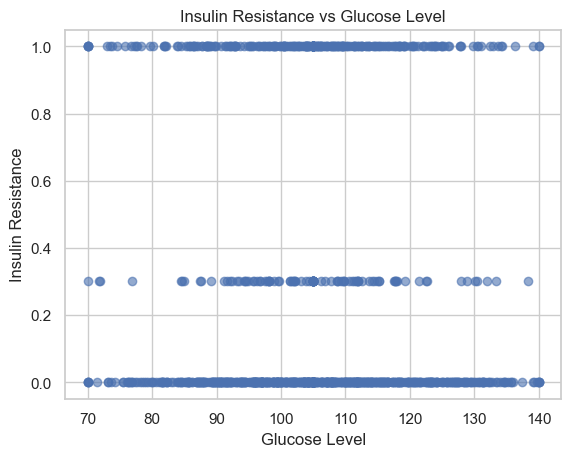

In [4]:
# Plotting the scatter plot
plt.scatter(df['BloodSugarLevel'], df['InsulinResistance'], alpha=0.6)

# Adding labels and title
plt.xlabel('Glucose Level')
plt.ylabel('Insulin Resistance')
plt.title('Insulin Resistance vs Glucose Level')

# Show plot
plt.show()

Now that we know there is an issue with the InsulinResistance column, we replace the mean-imputed values with NaN.

In [5]:
df['InsulinResistance'] = df['InsulinResistance'].apply(lambda x: x if x in [0, 1] else np.nan)


# Train-Test Split and Imputing missing values in the InsulinResistance Column

In [6]:
# Step 1: Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 2: Separate predictors and target in the training data
X_train = train_df.drop(columns=['InsulinResistance'])
y_train = train_df['InsulinResistance']

# Step 3: Remove rows where y_train is NaN for training the imputation model
X_train_notna = X_train[y_train.notna()]
y_train_notna = y_train[y_train.notna()]

# Check for NaNs in y_train_notna
print("NaNs in y_train_notna:", y_train_notna.isna().sum())

# Ensure y_train_notna contains only 0 or 1
print("Unique values in y_train_notna:", y_train_notna.unique())

# Step 4: Train the model for imputing the categorical column
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_notna, y_train_notna)

NaNs in y_train_notna: 0
Unique values in y_train_notna: [0. 1.]


RandomForestClassifier(random_state=42)

In [7]:
# Step 5: Impute missing values in the training set
missing_mask_train = y_train.isna()
X_train_missing = X_train[missing_mask_train]
if not X_train_missing.empty:
    train_df.loc[missing_mask_train, 'InsulinResistance'] = rf_model.predict(X_train_missing)

# Step 6: Apply the same steps to the test set
X_test = test_df.drop(columns=['InsulinResistance'])
y_test = test_df['InsulinResistance']
missing_mask_test = y_test.isna()
X_test_missing = X_test[missing_mask_test]

if not X_test_missing.empty:
    test_df.loc[missing_mask_test, 'InsulinResistance'] = rf_model.predict(X_test_missing)

# Now the train_df and test_df have imputed values for the 'InsulinResistance' column
train_df

,Age,Gender,Ethnicity,BMI,BloodSugarLevel,InsulinResistance,GeneticFactor
29,38,0,1,16.314598,98.140475,0.0,0.00
535,75,0,1,23.712571,113.753165,0.0,1.00
695,72,1,0,26.316953,105.053928,0.0,0.00
557,68,1,0,27.235889,129.831107,1.0,0.00
836,40,0,0,28.829069,139.071746,1.0,0.00
...,...,...,...,...,...,...,...
106,48,1,0,28.052368,113.284499,1.0,0.00
270,58,0,3,31.812547,128.443332,0.0,0.00
860,22,1,3,27.082437,111.387655,0.0,0.15
435,65,0,0,24.472501,86.373591,1.0,0.00


In [8]:
train_df['InsulinResistance'].value_counts()

InsulinResistance
0.0    576
1.0    224
Name: count, dtype: int64

In [9]:
test_df['InsulinResistance'].value_counts()

InsulinResistance
0.0    144
1.0     56
Name: count, dtype: int64

# Developing a model for comparision

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

models = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30]
    }),
    'LogisticRegression': (Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000))
    ]), {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
    }),
    'SVM': (Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC())
    ]), {
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [1, 10, 100]
    }),
    'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    })
}

# Set up outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each type of model
for name, (model, params) in models.items():
    # Set up inner cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    clf = GridSearchCV(estimator=model, param_grid=params, cv=inner_cv, scoring='accuracy')
    
    # Perform outer cross-validation
    outer_scores = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring='accuracy')
    
    # Print the results
    print(f"{name}: Mean accuracy = {np.mean(outer_scores):.3f} (+/- {np.std(outer_scores):.3f})")



RandomForest: Mean accuracy = 0.704 (+/- 0.025)
LogisticRegression: Mean accuracy = 0.720 (+/- 0.014)
SVM: Mean accuracy = 0.721 (+/- 0.008)
XGBoost: Mean accuracy = 0.681 (+/- 0.021)


In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report



# Initialize the SVM model
svm_model = SVC()

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions, target_names=['Absent', 'Present']))


              precision    recall  f1-score   support

      Absent       0.72      1.00      0.84       144
     Present       0.00      0.00      0.00        56

    accuracy                           0.72       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.52      0.72      0.60       200



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Value to compare to: accuracy of 0.721 

# Correcting the mean Imputation with more sophisticated Imputation methods

In [12]:
df.columns

Index(['Age', 'Gender', 'Ethnicity', 'BMI', 'BloodSugarLevel',
       'InsulinResistance', 'GeneticFactor'],
      dtype='object')

In [13]:
columns_with_mean_imputation = ['BMI', 'BloodSugarLevel']


def replace_mean_imputation_with_nan(df, columns, mean_values):
    """
    Replace mean-imputed values with NaN in the specified columns of a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    columns (list of str): The list of column names that had mean imputation applied.
    mean_values (dict): A dictionary with column names as keys and mean values as values.

    Returns:
    pd.DataFrame: The DataFrame with mean-imputed values replaced with NaN.
    """
    tolerance = 1e-6  # Increase tolerance
    for col in columns:
        mean_value = mean_values[col]
        print(f"Using mean value for column {col}: {mean_value}")  # Debug print
        df[col] = df[col].apply(lambda x: np.nan if np.abs(x - mean_value) < tolerance else x)
    return df


# Manually set the observed mean values for the columns
mean_values = {
    'BMI': 28.052368,
    'BloodSugarLevel': 105.053928  # Manually set the observed mean value
}

# Assuming X_train is your DataFrame
X_train = replace_mean_imputation_with_nan(X_train, columns_with_mean_imputation, mean_values)
X_test = replace_mean_imputation_with_nan(X_test, columns_with_mean_imputation, mean_values)



Using mean value for column BMI: 28.052368
Using mean value for column BloodSugarLevel: 105.053928
Using mean value for column BMI: 28.052368
Using mean value for column BloodSugarLevel: 105.053928


In [14]:
X_test['BMI'].value_counts(dropna=False)


BMI
NaN          11
18.815276     1
26.660899     1
21.910563     1
28.986019     1
             ..
32.497413     1
25.425801     1
34.570692     1
30.186934     1
28.096878     1
Name: count, Length: 190, dtype: int64

In [15]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Assuming X_train and X_test are already defined
# Ensure the columns are in the correct order

# Step 1: Initialize the imputers
knn_imputer = KNNImputer(n_neighbors=5)
rf_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)

# Step 2: Fit and transform the training data
X_train_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_train_rf_imputed = pd.DataFrame(rf_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

# Step 3: Transform the test data using the fitted imputers
X_test_knn_imputed = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_rf_imputed = pd.DataFrame(rf_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Optional: Compare imputations
# Here you can compare the results of the imputations if you have a ground truth or if you want to check the distributions

def compare_imputations(original, knn_imputed, rf_imputed, columns):
    comparison = pd.DataFrame({
        'Original': original[columns].mean(),
        'KNN Imputed': knn_imputed[columns].mean(),
        'RF Imputed': rf_imputed[columns].mean()
    })
    return comparison

# Specify columns with NaN values
columns_with_nan = ['BMI', 'BloodSugarLevel']

comparison_train = compare_imputations(X_train, X_train_knn_imputed, X_train_rf_imputed, columns_with_nan)
comparison_test = compare_imputations(X_test, X_test_knn_imputed, X_test_rf_imputed, columns_with_nan)

print("Comparison of Imputations on Training Data:")
print(comparison_train)
print("\nComparison of Imputations on Test Data:")
print(comparison_test)


Comparison of Imputations on Training Data:
                   Original  KNN Imputed  RF Imputed
BMI               27.913836    27.925542   27.926503
BloodSugarLevel  105.058688   105.052608  105.080385

Comparison of Imputations on Test Data:
                   Original  KNN Imputed  RF Imputed
BMI               28.573509    28.459159   28.562677
BloodSugarLevel  105.034754   104.946656  104.946356


/opt/homebrew/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [16]:
# Step 1: Initialize the Random Forest imputer
rf_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)

# Step 2: Fit the imputer on the training data
rf_imputer.fit(X_train)

# Step 3: Transform the training data
X_train_imputed = pd.DataFrame(rf_imputer.transform(X_train), columns=X_train.columns, index=X_train.index)

# Step 4: Transform the test data
X_test_imputed = pd.DataFrame(rf_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)


/opt/homebrew/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Fixing Genetic Factor

In [17]:
df.head(10) 

,Age,Gender,Ethnicity,BMI,BloodSugarLevel,InsulinResistance,GeneticFactor
0,56,0,1,18.303039,91.118631,0.0,0.00
1,69,0,4,28.052368,108.830756,NaN,0.00
2,46,1,4,30.947376,91.569805,0.0,0.00
3,32,1,0,26.874690,98.878487,NaN,0.00
4,60,1,3,28.052368,90.062769,0.0,0.00
5,25,1,4,30.063757,114.767044,0.0,0.00
6,78,1,0,21.749817,117.876767,NaN,0.00
7,38,0,2,25.883789,101.480691,0.0,0.00
8,56,0,4,31.177059,105.573570,1.0,0.15
9,75,0,0,22.982842,83.271129,0.0,0.00


In [18]:
X_train.columns

Index(['Age', 'Gender', 'Ethnicity', 'BMI', 'BloodSugarLevel',
       'GeneticFactor'],
      dtype='object')

In [19]:

def replace_with_nan(df, column_name, number_to_replace):
    """
    Replaces all instances of a certain number in a specified column of a DataFrame with NaN.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to modify.
    column_name (str): The name of the column to perform the replacement on.
    number_to_replace (int or float): The number to replace with NaN.
    
    Returns:
    pd.DataFrame: The DataFrame with the specified replacements.
    """
    df[column_name] = df[column_name].replace(number_to_replace, np.nan)
    return df

X_train = replace_with_nan(X_train_imputed, 'GeneticFactor', 0.15)
X_test = replace_with_nan(X_test_imputed, 'GeneticFactor', 0.15)

In [20]:
X_train_imputed['GeneticFactor'].value_counts(dropna=False)

GeneticFactor
0.0    602
1.0    114
NaN     84
Name: count, dtype: int64

In [21]:
def impute_genetic_factor(X_train_imputed, X_test):
    # Separate the rows with and without missing GeneticFactor
    train_with_genetic = X_train_imputed.dropna(subset=['GeneticFactor'])
    train_without_genetic = X_train_imputed[X_train['GeneticFactor'].isna()]
    
    # Prepare the training data for the model
    X_train_features = train_with_genetic.drop(columns=['GeneticFactor'])
    y_train_genetic = train_with_genetic['GeneticFactor']
    
    # Train the Random Forest model
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train_features, y_train_genetic)
    
    # Impute missing values in the training set
    if not train_without_genetic.empty:
        X_train_without_genetic_features = train_without_genetic.drop(columns=['GeneticFactor'])
        X_train.loc[X_train_imputed['GeneticFactor'].isna(), 'GeneticFactor'] = rf.predict(X_train_without_genetic_features)
    
    # Impute missing values in the test set
    test_missing_genetic = X_test[X_test['GeneticFactor'].isna()]
    if not test_missing_genetic.empty:
        X_test_features = X_test.drop(columns=['GeneticFactor'])
        X_test.loc[X_test_imputed['GeneticFactor'].isna(), 'GeneticFactor'] = rf.predict(X_test_features.loc[X_test['GeneticFactor'].isna()])
    
    return X_train, X_test

# Impute the missing values
X_train_imputed_genetic, X_test_imputed_genetic = impute_genetic_factor(X_train, X_test)


# Looking at Data after Preprocessing

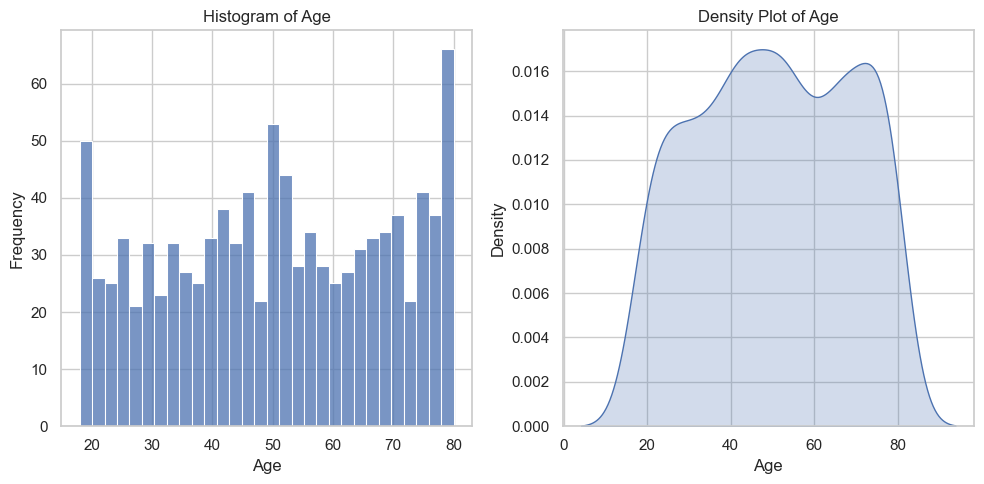

Statistics for Age:
count    1000.000000
mean       50.380000
std        18.378666
min        18.000000
25%        35.000000
50%        50.000000
75%        66.000000
max        80.000000
Name: Age, dtype: float64

Skewness: -0.06131207361588638

Kurtosis: -1.1659864966860525




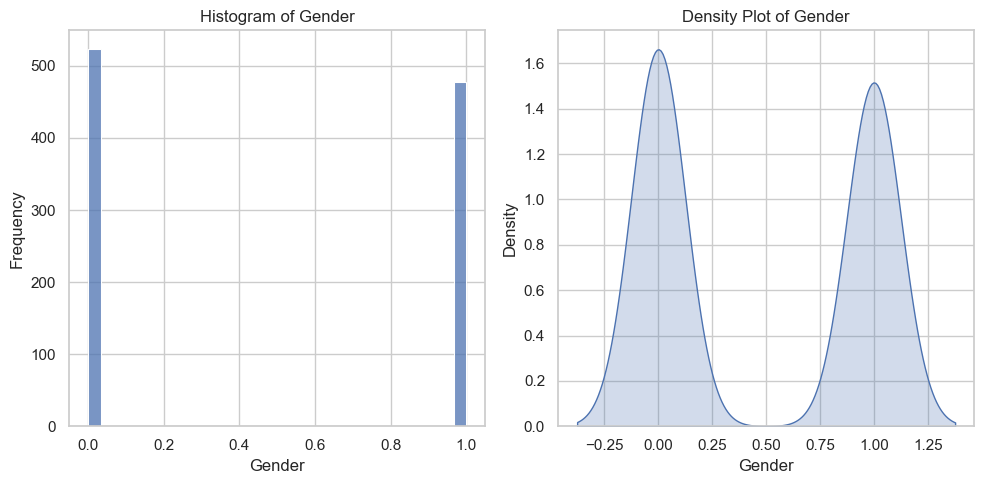

Statistics for Gender:
count    1000.000000
mean        0.477000
std         0.499721
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Gender, dtype: float64

Skewness: 0.0922359022863777

Kurtosis: -1.9954875253821585




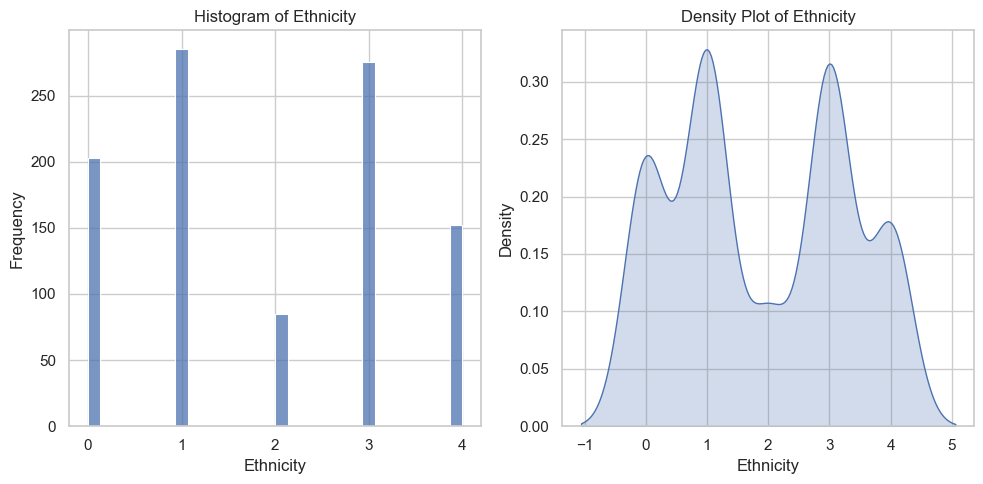

Statistics for Ethnicity:
count    1000.000000
mean        1.888000
std         1.403362
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Ethnicity, dtype: float64

Skewness: 0.088719786540836

Kurtosis: -1.3989569130713262




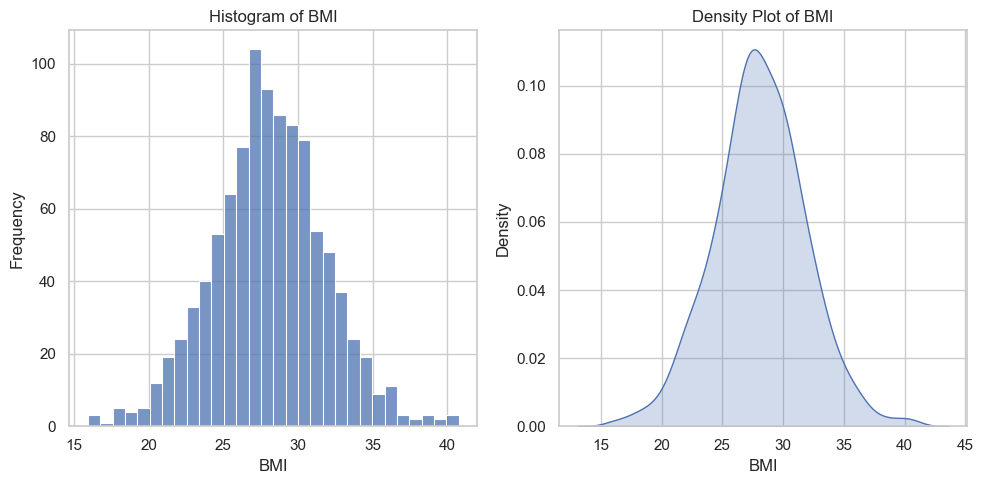

Statistics for BMI:
count    1000.000000
mean       28.062151
std         3.779672
min        15.921951
25%        25.732076
50%        28.009162
75%        30.442215
max        40.772430
Name: BMI, dtype: float64

Skewness: 0.019476585654236017

Kurtosis: 0.42655890838566934




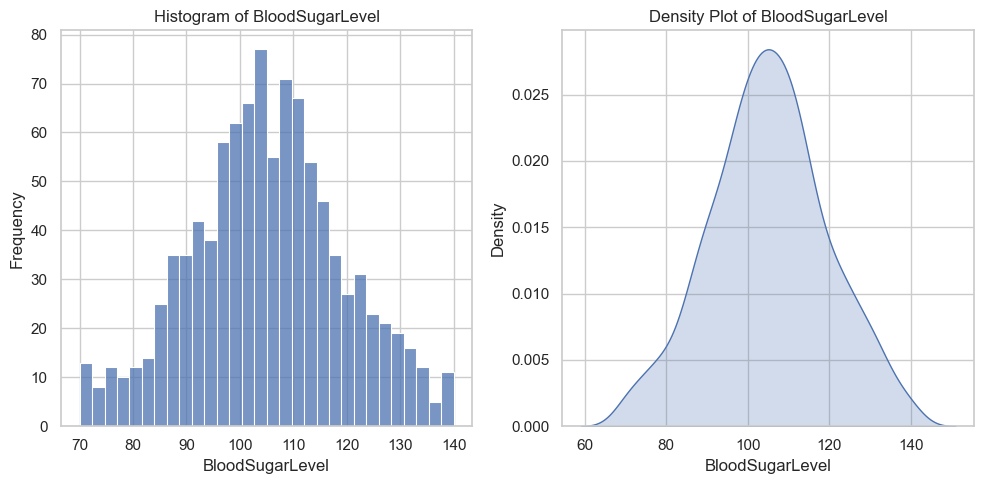

Statistics for BloodSugarLevel:
count    1000.000000
mean      105.072816
std        14.353427
min        70.000000
25%        95.887730
50%       104.642358
75%       114.131080
max       140.000000
Name: BloodSugarLevel, dtype: float64

Skewness: 0.0032752019238173726

Kurtosis: -0.20348970471795225




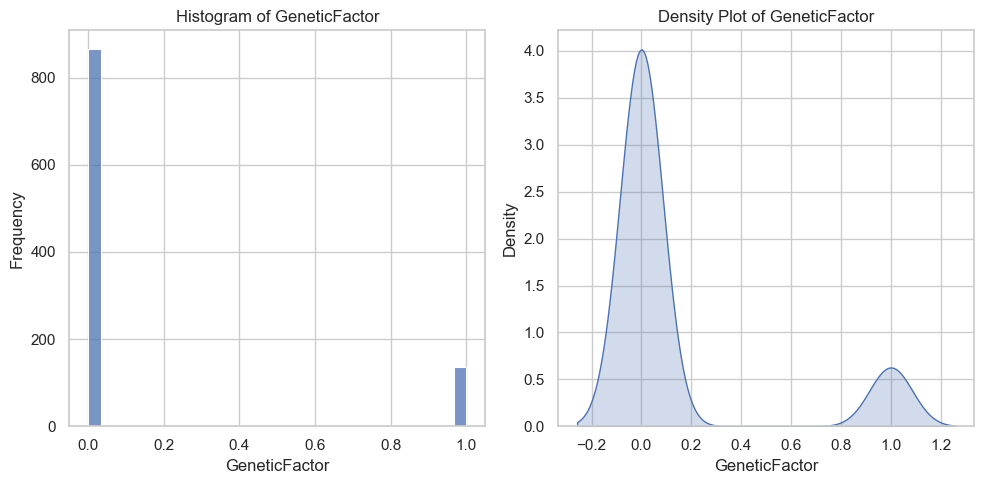

Statistics for GeneticFactor:
count    1000.000000
mean        0.135000
std         0.341895
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: GeneticFactor, dtype: float64

Skewness: 2.139440067210865

Kurtosis: 2.5823645365882064




In [22]:
combined_df = pd.concat([X_train_imputed_genetic, X_test_imputed_genetic])

plot_distributions(combined_df)



# Model on the Processed Data

In [31]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define models and hyperparameters
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

param_grids = {
    'RandomForest': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__class_weight': ['balanced', 'balanced_subsample', None]
    },
    'GradientBoosting': {
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7]
    },
    'SVM': {
        'clf__C': [0.1, 1, 10, 100],
        'clf__gamma': [1, 0.1, 0.01, 0.001],
        'clf__kernel': ['rbf', 'linear']
    }
}

# Define inner and outer cross-validation strategies
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a custom scorer
f1_scorer = make_scorer(f1_score, average='macro')


In [32]:
def nested_cv(X, y, models, param_grids, inner_cv, outer_cv, scorer):
    outer_scores = {}

    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")

        # Create a pipeline with SMOTE and the classifier
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('clf', model)
        ])

        # Create a GridSearchCV object
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=inner_cv, scoring=scorer, n_jobs=-1)

        # Perform outer cross-validation
        scores = cross_val_score(grid_search, X, y, cv=outer_cv, scoring=scorer, n_jobs=-1)
        outer_scores[model_name] = scores

        print(f"Model: {model_name}, Mean F1 Score: {np.mean(scores):.4f}, Std F1 Score: {np.std(scores):.4f}")

    return outer_scores

# Perform nested cross-validation
nested_scores = nested_cv(X_train_imputed_genetic, y_train, models, param_grids, inner_cv, outer_cv, f1_scorer)


Evaluating model: RandomForest
Model: RandomForest, Mean F1 Score: 0.5273, Std F1 Score: 0.0539
Evaluating model: GradientBoosting
Model: GradientBoosting, Mean F1 Score: 0.5119, Std F1 Score: 0.0410
Evaluating model: SVM


KeyboardInterrupt: 

In [ ]:
# Select the best model (example with RandomForest)
best_model_name = max(nested_scores, key=lambda k: np.mean(nested_scores[k]))
best_model = models[best_model_name]
best_params = param_grids[best_model_name]

# Perform a final fit on the training data with GridSearchCV
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', GridSearchCV(best_model, best_params, cv=inner_cv, scoring=f1_scorer, n_jobs=-1))
])
pipeline.fit(X_train_imputed_genetic, y_train)

# Extract the best model from the pipeline
best_estimator = pipeline.named_steps['clf'].best_estimator_

# Make predictions on the test data
predictions = best_estimator.predict(X_test_imputed_genetic)

# Evaluate the final model
print(classification_report(y_test, predictions, target_names=['Absent', 'Present']))
 

In [24]:
print(len(X_train_imputed_genetic))
print(len(X_test_imputed_genetic))
print(len(y_train))
print(len(y_test))

800
200
800
200


In [25]:
print(f"Shape of X_test_imputed_genetic: {X_test_imputed_genetic.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_test_imputed_genetic: (200, 6)
Shape of y_test: (200,)


# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForest model with class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model on the training data
rf_model.fit(X_train_imputed_genetic, y_train)

# Make predictions on the test data
predictions = rf_model.predict(X_test_imputed_genetic)

# Evaluate the model
print(classification_report(y_test, predictions, target_names=['Absent', 'Present']))


              precision    recall  f1-score   support

      Absent       0.72      0.90      0.80       144
     Present       0.25      0.09      0.13        56

    accuracy                           0.67       200
   macro avg       0.48      0.49      0.46       200
weighted avg       0.59      0.67      0.61       200



## SMOTE 

In [27]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed_genetic, y_train)

# Initialize the RandomForest model
rf_model_smote = RandomForestClassifier(random_state=42)

# Fit the model on the oversampled training data
rf_model_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
predictions_smote = rf_model_smote.predict(X_test_imputed_genetic)

# Evaluate the model
print(classification_report(y_test, predictions_smote, target_names=['Absent', 'Present']))


              precision    recall  f1-score   support

      Absent       0.72      0.83      0.77       144
     Present       0.26      0.16      0.20        56

    accuracy                           0.64       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.59      0.64      0.61       200



In [28]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Apply RandomUnderSampler to the training data
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_imputed_genetic, y_train)

# Initialize the RandomForest model
rf_model_rus = RandomForestClassifier(random_state=42)

# Fit the model on the undersampled training data
rf_model_rus.fit(X_train_rus, y_train_rus)

# Make predictions on the test data
predictions_rus = rf_model_rus.predict(X_test_imputed_genetic)

# Evaluate the model
print(classification_report(y_test, predictions_rus, target_names=['Absent', 'Present']))


              precision    recall  f1-score   support

      Absent       0.68      0.53      0.60       144
     Present       0.23      0.36      0.28        56

    accuracy                           0.48       200
   macro avg       0.46      0.45      0.44       200
weighted avg       0.55      0.48      0.51       200



In [29]:
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Apply SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train_imputed_genetic, y_train)

# Initialize the RandomForest model
rf_model_smoteenn = RandomForestClassifier(random_state=42)

# Fit the model on the resampled training data
rf_model_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# Make predictions on the test data
predictions_smoteenn = rf_model_smoteenn.predict(X_test_imputed_genetic)

# Evaluate the model
print(classification_report(y_test, predictions_smoteenn, target_names=['Absent', 'Present']))


              precision    recall  f1-score   support

      Absent       0.71      0.48      0.57       144
     Present       0.27      0.50      0.35        56

    accuracy                           0.48       200
   macro avg       0.49      0.49      0.46       200
weighted avg       0.59      0.48      0.51       200

